# FISH integrated analyses

## Libraries

In [1]:
# Importing libraries
# Image reader
from skimage import io ; from skimage.io import imread
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
import matplotlib.path as mpltPath
import numpy as np 
import pandas as pd
import pathlib
# Figure style and size
import warnings
warnings.filterwarnings("ignore")
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection

from scipy import ndimage

## Directories Path

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('MS2-Cy3')
data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('GAPDH_Exon_Cy5')

In [3]:
# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

2021-10-26 12:06:06,533 [INFO] WRITING LOG OUTPUT TO /home/luisub/.cellpose/run.log


## Loading Files

In [4]:
#list_file_names, list_merged_images, number_images, output_to_path = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =0).merge()
list_images, path_files, list_files_names, number_images = fa.ReadImages(data_dir).read()

In [5]:
selected_image = 0
channel_with_cytosol = [1,2]   # list or int
channel_with_nucleus = 0      # list or int
FISH_channel = 1              # int specific channel with FISH spots that are used for the quantification

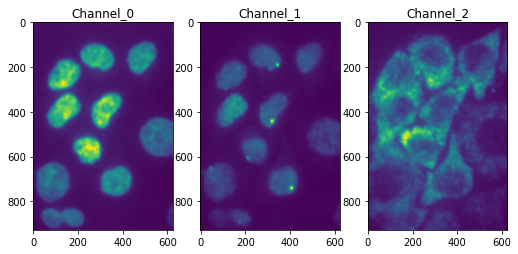

In [6]:
fa.PlotImages (list_images[selected_image],figsize=(8.5, 5) ).plot()

### Parameters for segmentation

In [7]:
diamter_nucleus = 200         #approximated nucleus size in pixels
diameter_cytosol = 250        # approximated cytosol size in pixels

## Cell Segmentation

2021-10-26 12:06:12,789 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 12:06:12,790 [INFO] >>>> using GPU
2021-10-26 12:06:12,932 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 12:06:12,933 [INFO] >>>> using GPU
2021-10-26 12:06:12,982 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 12:06:13,542 [INFO] >>>> TOTAL TIME 0.56 sec
2021-10-26 12:06:13,551 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 12:06:13,959 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 12:06:13,965 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 12:06:14,373 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 12:06:14,380 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 12:06:14,779 [INFO] >>>> TOTAL TIME 0.40 sec
2021-10-26 12:06:14,784 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 12:06:15,181 [INFO] >>>> TOTAL TIME 0.40 sec
2021-10-26 12:06:15,187 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 12:06:15,597 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 12:06:15,599 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 12:06:

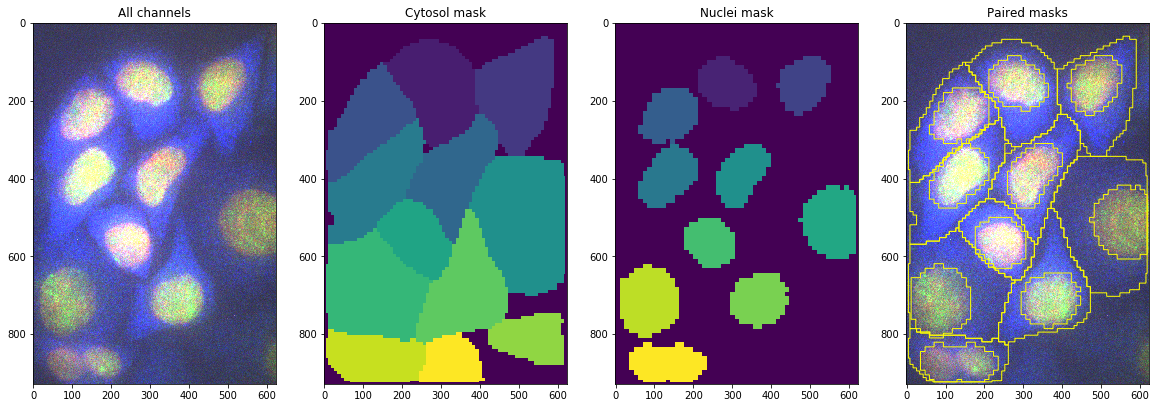

In [8]:
remove_fragmented_cells = False

masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, index_paired_masks = fa.CellSegmentation(list_images[selected_image],channel_with_cytosol=channel_with_cytosol, channel_with_nucleus=channel_with_nucleus,diameter_cytosol = diameter_cytosol, diamter_nucleus=diamter_nucleus,remove_fragmented_cells= remove_fragmented_cells, show_plot=1).calculate_masks()  # Detect only nucleus

## Spot Detection

### Parameters for spot detection

In [9]:
# Parameters for FISH detection
# Average spot size and shape
voxel_size_z = 300     # Height of a voxel, along the z axis, in nanometer. If None, image is considered in 2-d.
voxel_size_yx = 150    # Size of a voxel on the yx plan, in nanometer.
psf_z = 350            # Theoretical size of the PSF emitted by a spot in the z plan, in nanometer. If None, image is considered in 2-d.
psf_yx = 150           # Theoretical size of the PSF emitted by a spot in the yx plan, in nanometer.
# Cluster Detection
cluster_radius=500     # The maximum distance between two samples for one to be considered as in the neighborhood of the other. Radius expressed in nanometer.
minimum_spots_cluster=4   #The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.

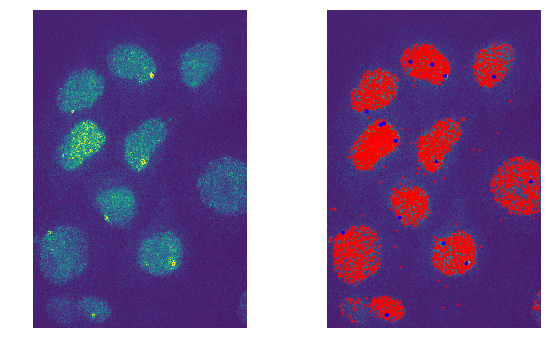

In [10]:
[spotDectionCSV, clusterDectionCSV] = fa.SpotDetection(list_images[selected_image],FISH_channel, voxel_size_z = voxel_size_z,voxel_size_yx = voxel_size_yx,psf_z = psf_z, psf_yx = psf_yx,cluster_radius=cluster_radius,minimum_spots_cluster=minimum_spots_cluster, show_plot=1).detect()

In [11]:
dataframe, counter_total_cells = fa.DataProcessing(spotDectionCSV, clusterDectionCSV,masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, counter_total_cells=0,dataframe =None).get_dataframe()

ValueError: too many values to unpack (expected 2)

In [ ]:
dataframe.h

In [ ]:
'''
mask_num = 3
plt.imshow(masks_complete_cells[mask_num])
plt.show()
plt.imshow(masks_nuclei[mask_num])
plt.show()
plt.imshow(masks_cytosol_no_nuclei[mask_num])
plt.show()
'''